# Neural System Identification

This notebook accompanies our submitted paper "Neural Nonlinear State-Space Identification".

## 1. Introduction

## 2. Background

The nonlinear system identification problem is to find an autoregressive model $f$ where the current output depends on delayed outputs $y$ and control inputs $u$,
%
\begin{equation}
    y(t) = f(y(t-1),y(t-2),\ldots,y(t-L),u(t-1),u(t-2),\ldots,u(t-L)) + \epsilon \enspace ,
\end{equation}
%
where $\epsilon$ is white noise, $t$ is the sample index (time instant), and $L$ is the number of past samples. The model function $f(\cdot)$ is generally unknown, but can be approximated by a neural network $f_\theta$ parametrized with $\theta$ which are optimized using training samples.

### 2.2 Modeling sequential data

#### Simple pendulum

The illustrative environment is the Gymnasium environment *Pendulum* 

<div><img src="images/pendulum.png"/></div>

The observation space $\mathbf{y}$ is (note that x and y denote the cartesian coordinates below)

 * $y_0 = x = \cos\theta$
 * $y_1 = y = \sin\theta$
 * $y_2 = \dot\theta$

The action space is the produced torque

 * $u \in [-2,+2]$

The initial state is

 * $\theta_0 \in [ -180,+180 ]$
 * $\dot\theta_0 \in [ -1,+1 ]$   

The full description is available at the Gymnasium::[pendulum](https://gymnasium.farama.org/environments/classic_control/pendulum/).

**Gymnasium API** Install Gymnasium and then create the Pendulum environment

In [1]:
import gymnasium as gym
import numpy as np
env = gym.make('Pendulum-v1', g=9.81)

print(env.action_space.shape[0])
print(env.observation_space.shape[0])

1
3


**Trajectory** Generate trajectory of variable length between 100 and 200 samples. This corresponds to real data where recorded trajectories can have different number of samples, and we must deal with them.

In [2]:
def gen_trajectory(env_, traj_len_):

    observation, info = env_.reset()

    u_vec = np.empty((traj_len_,env_.action_space.shape[0]))
    y_vec = np.empty((traj_len_,env_.observation_space.shape[0]))

    for t in range(traj_len_):
        y_vec[t,:] = observation
        action = [0]
        u_vec[t] = action
        observation, reward, terminated, truncated, info = env.step(action)
    return y_vec, u_vec, t
foo,_,_ = gen_trajectory(env, 100)
print(foo.shape)
print(f'Starting point is theta={foo[0,:]}')

(100, 3)
Starting point is theta=[-0.3814888  -0.92437345  0.28163823]


**Example 1** Plot the state variables. Re-run until you see three sinusoidal curves.

Starting point is theta=[-0.80196804 -0.59736693 -0.58976299]


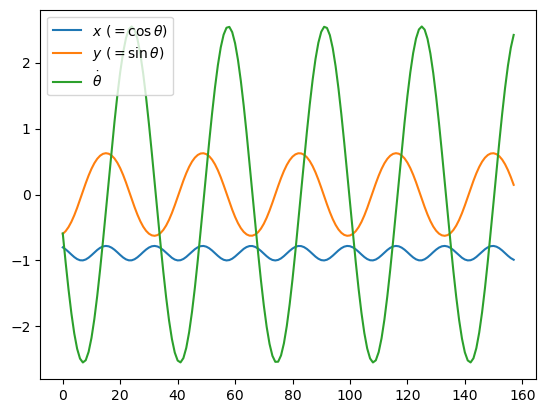

In [3]:
import matplotlib.pyplot as plt

y_vec, u_vec, t_max = gen_trajectory(env,np.random.randint(100,high=201))
print(f'Starting point is theta={y_vec[0,:]}')
plt.plot(range(t_max), y_vec[:t_max,:],label=[r'$x~(=\cos\theta)$', r'$y~(=\sin\theta)$', r'$\dot\theta$'])
plt.legend()
plt.savefig('pendulum_example1.png')
plt.show()

**Example 2** Re-run until you see non-sinusoidal curves

Starting point is theta=[ 0.94868386  0.31622615 -0.76203442]


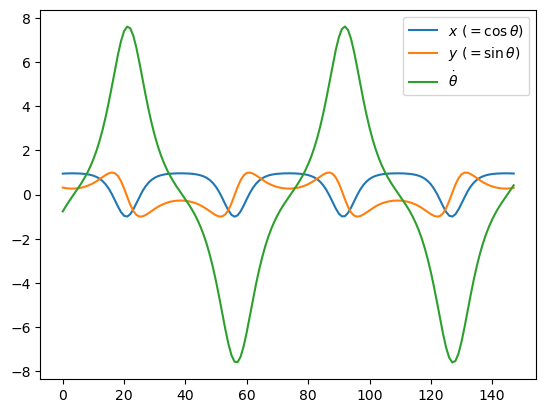

In [6]:
y_vec, u_vec, t_max = gen_trajectory(env,np.random.randint(100,high=201))
print(f'Starting point is theta={y_vec[0,:]}')
plt.plot(range(t_max), y_vec[:t_max,:],label=[r'$x~(=\cos\theta)$', r'$y~(=\sin\theta)$', r'$\dot\theta$'])
plt.legend()
plt.savefig('pendulum_example2.png')
plt.show()

**Findings:** The nonlinearities may prevent linear models to capture the data. 

**Resticted pendulum** For simplicity (and sinusoidal outputs) we wish to start pendulum always pointing downwards and with small initial velocity (not to allow move upward). It is cumbersome to rewrite the env.reset() function and therefore we wrap it by simple tria-and-error function. 

In [7]:
def pendulum_env_reset(env_):
    observation, info = env_.reset()
    while observation[0] > 0 or abs(observation[2]) > 0.1:
        observation, info = env_.reset()
    return observation,info

Rewrite the trajectory generation (re-run and make sure x (var[0]) is always negative and velocity (var[2]) is always less that 0.2

Starting point is theta=[-9.56006944e-02 -9.95419741e-01  2.80152653e-05]


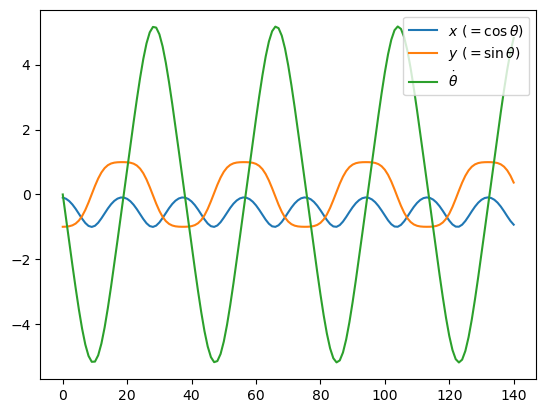

In [8]:
def gen_trajectory_restricted(env_, traj_len_):

    observation, info = pendulum_env_reset(env_)

    u_vec = np.empty((traj_len_,env_.action_space.shape[0]))
    y_vec = np.empty((traj_len_,env_.observation_space.shape[0]))

    for t in range(traj_len_):
        y_vec[t,:] = observation
        action = [0]
        u_vec[t] = action
        observation, reward, terminated, truncated, info = env.step(action)
    return y_vec, u_vec, t

# Verify it works
y_vec, u_vec, t_max = gen_trajectory_restricted(env,np.random.randint(100,high=201))
print(f'Starting point is theta={y_vec[0,:]}')
plt.plot(range(t_max), y_vec[:t_max,:],label=[r'$x~(=\cos\theta)$', r'$y~(=\sin\theta)$', r'$\dot\theta$'])
plt.legend()
plt.show()

#### MLP regression

Let's train an MLP neural network using the current state variables at time instant $t-1$
$$
\vec{x}_{t-1} = (\cos\theta_{t-1}, \sin\theta_{t-1}, \dot\theta_{t-1})^T
$$
as input, and their new predicted values as output
$$
\vec{y}_t = f(\vec{x}_{t-1}) = \hat{\vec{x}}_t  \enspace ,
$$
where $\hat{\vec{x}}_t$ denotes an estimate of the true value $\vec{x}_t$.

Collect a training dataset of $N_{tr}$ samples. If the environment is terminated, it is restarted until enough samples in the training buffer. Let's utilize the following heuristic training steps:

 * Find a network structure and number of epochs so that the network completely learns 10 episodes (can overfit to data)
 * Search which error level should be achieved until training fit is good, and then add neurons and training data to achieve the same with validation data
 * Increase number of samples until it does not anymore overfit
 * Optimize everything for the validation data

Collect training data by sampling N training trajectories (of varying length)

In [9]:
num_of_tr_trajs = 10

samples_tr = []

tot_samples = 0
for t in range(num_of_tr_trajs):
    y_vec, u_vec, t_max = gen_trajectory_restricted(env,np.random.randint(100,high=201))
    tot_samples += t_max+1
    
    samples_tr.append(y_vec)
print(f'Generated the total of {tot_samples} samples')

Generated the total of 1494 samples


In [10]:
print(samples_tr[0].shape)

(122, 3)


For input x and output y for regression y=f(x) so that x is always the previous sample $x=y_{t-1}$ for the current output $y_t$. 

In [11]:
import torch

s = samples_tr[0]
X_tr = torch.from_numpy(s[:-1])
Y_tr = torch.from_numpy(s[1:])
for t in range(1,len(samples_tr)):
    s = samples_tr[t]
    X = torch.from_numpy(s[:-1])
    Y = torch.from_numpy(s[1:])
    X_tr = torch.cat((X_tr,X),0)
    Y_tr = torch.cat((Y_tr,Y),0)
print(X_tr.shape)
print(Y_tr.shape)

torch.Size([1484, 3])
torch.Size([1484, 3])


#### Example: Training MLP for a fully observable environment

In [12]:
import torch
 
model = torch.nn.Sequential()
model.add_module("dense1", torch.nn.Linear(3, 16))
model.add_module("act1", torch.nn.Sigmoid())
model.add_module("dense2", torch.nn.Linear(16, 16))
model.add_module("act2", torch.nn.Sigmoid())
model.add_module("output", torch.nn.Linear(16, 3))

print(model)

Sequential(
  (dense1): Linear(in_features=3, out_features=16, bias=True)
  (act1): Sigmoid()
  (dense2): Linear(in_features=16, out_features=16, bias=True)
  (act2): Sigmoid()
  (output): Linear(in_features=16, out_features=3, bias=True)
)


Define loss and the optimizer

In [13]:
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train the model for some epochs (you should obtain training error below 0.03)

In [14]:
num_of_epochs = 2000

model.train()
for n in range(num_of_epochs):
    Y_pred = model(X_tr.float())
    loss = loss_fn(Y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 100 == 0:
            print(f'   Epoch {n} training loss {loss.item()}')

   Epoch 0 training loss 1.2436856566094174
   Epoch 100 training loss 0.8608931554306188
   Epoch 200 training loss 0.7073272333945556
   Epoch 300 training loss 0.3738453105195703
   Epoch 400 training loss 0.31749310872139097
   Epoch 500 training loss 0.2739252898851928
   Epoch 600 training loss 0.19169142791919364
   Epoch 700 training loss 0.13306588265508906
   Epoch 800 training loss 0.11334020258498571
   Epoch 900 training loss 0.09904680692580105
   Epoch 1000 training loss 0.08763395170627834
   Epoch 1100 training loss 0.08011127266597115
   Epoch 1200 training loss 0.07528409753838865
   Epoch 1300 training loss 0.07169223327986915
   Epoch 1400 training loss 0.06888513372938448
   Epoch 1500 training loss 0.06615137812951981
   Epoch 1600 training loss 0.0631393327542266
   Epoch 1700 training loss 0.059857327511598106
   Epoch 1800 training loss 0.0562694188059803
   Epoch 1900 training loss 0.052719617723384814


**On training data** Verify fit quality by testing how well the model can represent the training data

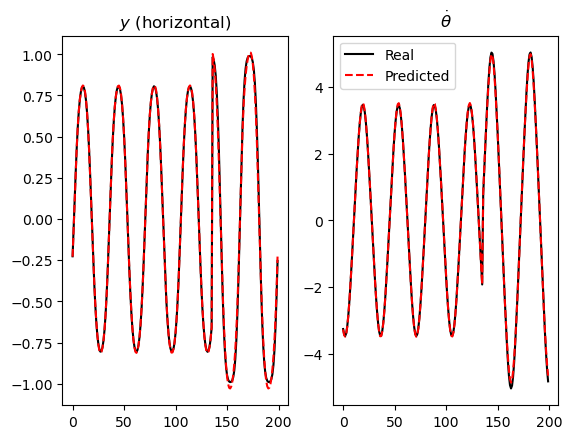

In [15]:
start_ind = np.random.randint(0,X_tr.shape[0])

model.eval()
Y_hat = model(X_tr[start_ind:start_ind+200].float()).detach()

plt.subplot(1,2,1)
plt.title(r'$y$ (horizontal)')
plt.plot(range(200), Y_tr[start_ind:start_ind+200,1], 'k-', range(200), Y_hat[:,1], 'r--')
plt.subplot(1,2,2)
plt.plot(range(200), Y_tr[start_ind:start_ind+200,2], 'k-', range(200), Y_hat[:,2], 'r--')
plt.title(r'$\dot\theta$')
plt.legend(['Real', 'Predicted'])
plt.show()

**On test data** Generate a new trajectory and test

In [16]:
y_vec, u_vec, t_max = gen_trajectory_restricted(env,np.random.randint(100,high=201))

X_te = torch.from_numpy(y_vec[:-1])
Y_te = torch.from_numpy(y_vec[1:])
print(X_te.shape)
print(Y_te.shape)

torch.Size([182, 3])
torch.Size([182, 3])


Compute predictions

In [17]:
Y_hat = model(X_te.float()).detach()

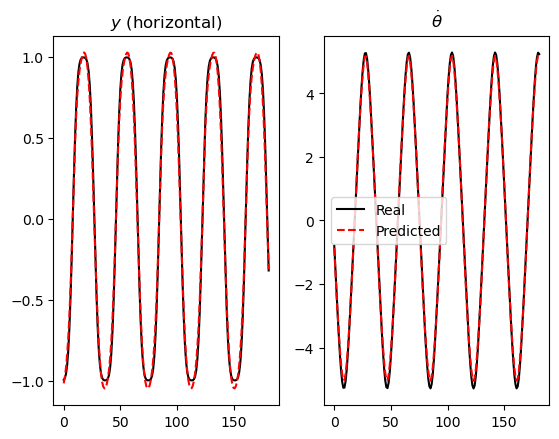

In [18]:
plt.subplot(1,2,1)
plt.title(r'$y$ (horizontal)')
plt.plot(range(t_max), Y_te[:n,1], 'k-', range(t_max), Y_hat[:n,1], 'r--')
plt.subplot(1,2,2)
plt.plot(range(t_max), Y_te[:n,2], 'k-', range(t_max), Y_hat[:n,2], 'r--')
plt.title(r'$\dot\theta$')
plt.legend(['Real', 'Predicted'])
plt.savefig('mlp_prediction.png')
plt.show()

**Generative mode** Generate the trajectory from the first sample

In [19]:
Y_hat = torch.empty(Y_te.shape)

Y_hat[0,:] = model(X_te[0,:].float())

for te_ind in range(1,Y_te.shape[0]):
    Y_hat[te_ind,:] = model(Y_hat[te_ind-1,:])
Y_hat = Y_hat.detach()

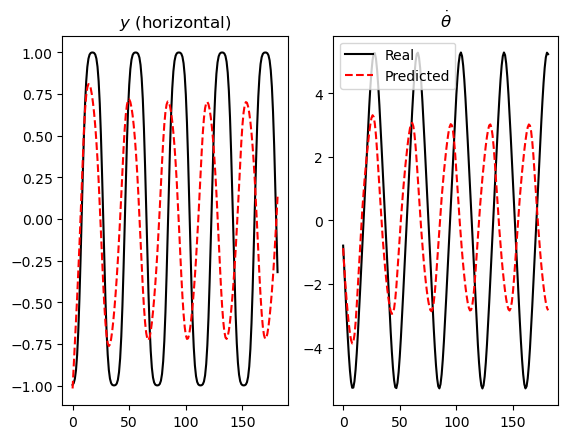

In [20]:
plt.subplot(1,2,1)
plt.title(r'$y$ (horizontal)')
plt.plot(range(t_max), Y_te[:n,1], 'k-', range(t_max), Y_hat[:n,1], 'r--')
plt.subplot(1,2,2)
plt.plot(range(t_max), Y_te[:n,2], 'k-', range(t_max), Y_hat[:n,2], 'r--')
plt.title(r'$\dot\theta$')
plt.legend(['Real', 'Predicted'])
plt.savefig('mlp_generated.png')
plt.show()

**Findings:** Sometimes MLP works fine (when the first prediction is about correct), but sometimes behavior is not what happens in the training data (not continuous sinusoid)

#### LSTM

Let's see how much better in sequence modeling is LSTM network

In [55]:
class myLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = torch.nn.LSTM(input_size, hidden_size) # 1 input feature 50 hidden units
        self.linear = torch.nn.Linear(hidden_size, output_size) # convert hidden state to prediction


    def forward(self, X, h_t=None, c_t=None):
        if h_t is None:
          outputs, (h_t, c_t) = self.lstm(X)
          outputs = self.linear(outputs)
        else:
          outputs, (h_t, c_t) = self.lstm(X,(h_t,c_t))
          outputs = self.linear(outputs)

        return outputs, h_t, c_t

In [64]:
model_rnn = myLSTM(samples_tr[0].shape[1],32,samples_tr[0].shape[1])

loss_fn_rnn = torch.nn.L1Loss()
#loss_fn_rnn = torch.nn.MSELoss()
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

Convert data to the sequential learning form, i.e. N samples are used to predict sample N+1

In [97]:
num_of_epochs = 100
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.00001)
model_rnn.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    for s in samples_tr:
        X = torch.from_numpy(s[:-1]).float()
        Y = torch.from_numpy(s[1:]).float()
        optimizer_rnn.zero_grad()
        Y_pred, _, _ = model_rnn(X)
        loss = loss_fn_rnn(Y_pred,Y)
        loss.backward()
        optimizer_rnn.step()
        running_loss += loss.item()
    if n % 10 == 0:
        print(f'   Epoch {n} training loss {running_loss}')

   Epoch 0 training loss 0.05110911559313536
   Epoch 10 training loss 0.050589984748512506
   Epoch 20 training loss 0.050549439154565334
   Epoch 30 training loss 0.05050224415026605
   Epoch 40 training loss 0.05046615842729807
   Epoch 50 training loss 0.05042641842737794
   Epoch 60 training loss 0.05039805080741644
   Epoch 70 training loss 0.05035226186737418
   Epoch 80 training loss 0.05031196121126413
   Epoch 90 training loss 0.05026358435861766


In [98]:
y_vec, u_vec, t_max = gen_trajectory_restricted(env,np.random.randint(100,high=201))

X_te = torch.from_numpy(y_vec[:-1])
Y_te = torch.from_numpy(y_vec[1:])
print(X_te.shape)
print(Y_te.shape)

torch.Size([132, 3])
torch.Size([132, 3])


In [99]:
model_rnn.eval()

Y_hat = torch.empty(Y_te.shape)
Y_hat[0,:], h_t, c_t = model_rnn(X_te[0,:].view(1,-1).float())

for te_ind in range(1,Y_te.shape[0]):
    Y_hat[te_ind,:], h_t, c_t = model_rnn(Y_hat[te_ind-1,:].view(1,-1), h_t, c_t)
Y_hat = Y_hat.detach()

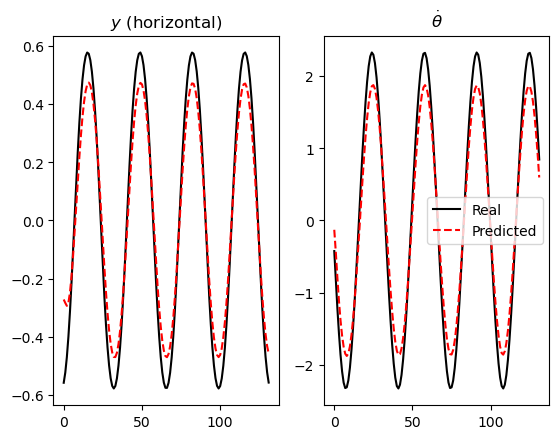

In [100]:
plt.subplot(1,2,1)
plt.title(r'$y$ (horizontal)')
plt.plot(range(Y_te.shape[0]), Y_te[:,1], 'k-', range(Y_te.shape[0]), Y_hat[:,1], 'r--')
plt.subplot(1,2,2)
plt.plot(range(Y_te.shape[0]), Y_te[:,2], 'k-', range(Y_te.shape[0]), Y_hat[:,2], 'r--')
plt.title(r'$\dot\theta$')
plt.legend(['Real', 'Predicted'])
plt.savefig('mlp_generated.png')
plt.show()

Results show that the first 1-2 estimates are close to the starting point, but otherwise estimates are wrong. For example, what happens next is very different for a pendulum swinging from left to right than right to left. And the first action has very little effect to that.